# 11 - Climatological ESP forecasting

## Extended Streamflow Prediction (ESP) forecasts from climatological time series

This notebook shows how to perform a climatological Extended Streamflow Prediction (ESP) forecast, using historical weather as a proxy for future weather.

The general idea is to initialize the state of the hydrological model to represent current conditions, but instead of using weather forecasts to predict future flows, we run the model with observed, historical weather series from past years. So for example if we have 30 years of weather observations, we get 30 different forecasts. The accuracy of this forecast ensemble can then be evaluated by different probabilistic metrics.

In [1]:
import datetime as dt

from matplotlib import pyplot as plt

from ravenpy import Emulator, RavenWarning
from ravenpy.new_config import commands as rc
from ravenpy.new_config.emulators import GR4JCN
from ravenpy.utilities.new_config import forecasting
from ravenpy.utilities.testdata import get_file

## Run the model simulations

Here we set model parameters somewhat arbitrarily, but you can set the parameters to the calibrated parameters as seen in the "06_Raven_calibration" notebook we previously encountered.

We also need to choose the forecast issue date. Each forecast will start with the same day and month. For example, jun-06-1980 will compare the climatology using all jun-06's from the dataset. Finally, we can provide the forecast duration (in number of days) as well as the historical meteorological years we want to use to generate the ESP forecast. This allows selecting years that we want to include in the forecast. For example, perhaps we only want to generate a forecast using wet or dry years.

In [2]:
# Get the selected watershed's time series. You can use your own time-series for your catchment by replacing
# this line with the name / path of your input file.
ts = get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc")

# This is the forecast start date, on which the forecasts will be launched.
start_date = dt.datetime(1980, 6, 1)

# Provide the length of the forecast, in days:
forecast_duration = 100

# Define HRU to build the hydrological model
hru = {}
hru = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    hru_type="land",
)

# Set alternative names for netCDF variables
alt_names = {
    "TEMP_MIN": "tmin",
    "TEMP_MAX": "tmax",
    "RAINFALL": "rain",
    "SNOWFALL": "snow",
}

# Data types to extract from netCDF
data_type = ["TEMP_MAX", "TEMP_MIN", "RAINFALL", "SNOWFALL"]
data_kwds = {
    "ALL": {
        "elevation": hru[
            "elevation"
        ],  # No need for lat/lon as they are included in the netcdf file already
    }
}
# Model configuration
model_config = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            ts, data_type=data_type, alt_names=alt_names, data_kwds=data_kwds
        )
    ],
    HRUs=[hru],
    StartDate=start_date,
    Duration=forecast_duration,
    RunName="full",
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
)

### Issuing the ESP forecast

Here we launch the code that will perform the ESP forecast. Depending on the number of years in the historical dataset and the forecast duration, it might take a while to return a forecast result.

In [4]:
%%capture --no-display
# Adding this to avoid spamming warning messages for overwriting files.

# Simulate the climatological ESP:
ESP_sims = forecasting.climatology_esp(
    config=model_config,
    years=[
        1982,
        1998,
        2003,
        2004,
    ],  # List of years to use in the forecast. Optional. Will use all years by default.
)

# Show the results in an xarray dataset, ready to use:
ESP_sims.hydrograph

<xarray.Dataset>
Dimensions:     (member: 4, time: 101, nbasins: 1)
Coordinates:
  * member      (member) int64 1982 1998 2003 2004
  * time        (time) datetime64[ns] 1980-06-01 1980-06-02 ... 1980-09-09
    basin_name  (nbasins) object 'sub_001'
Dimensions without coordinates: nbasins
Data variables:
    precip      (member, time) float64 nan 2.035 1.133 ... 0.01012 9.878 7.834
    q_sim       (member, time, nbasins) float64 28.08 14.2 ... 1.637 4.855
    q_obs       (member, time, nbasins) float64 nan nan nan nan ... nan nan nan
    q_in        (member, time, nbasins) float64 nan nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created by Raven
    description:  Standard Output

We can now inspect and graph the resulting climatological ESP:

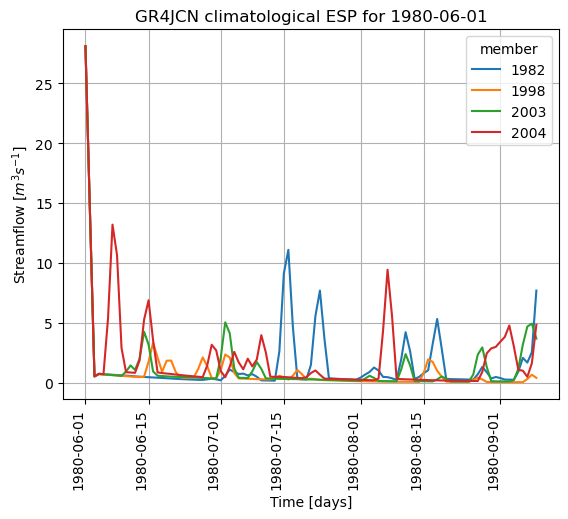

In [5]:
ESP_sims.hydrograph.q_sim[:, :, 0].plot.line(x="time")
plt.title("GR4JCN climatological ESP for 1980-06-01")
plt.xticks(rotation=90)
plt.grid("on")
plt.xlabel("Time [days]")
plt.ylabel("Streamflow $[m^3s^{-1}]$")
plt.show()

## Compute the forecast scores

There are different metric to evaluate the performance of forecasts. As an example, here we are computing the CRPS metric, using the [xskillscore](https://xskillscore.readthedocs.io/en/stable/) library included in PAVICS-Hydro.

In [6]:
import numpy as np
import xarray as xr
import xskillscore as xs

# Align time axes to get the observed streamflow time series for the same time frame as the ESP forecast ensemble
q_obs, q_sims = xr.align(xr.open_dataset(ts).qobs, ESP_sims.hydrograph, join="inner")

# Adjust the streamflow to convert missing data from -1.2345 format to NaN. Set all negative values to NaN.
q_obs = q_obs.where(q_obs > 0, np.nan)

# Compute the Continuous Ranked Probability Score using xskillscore
xs.crps_ensemble(q_obs, q_sims, dim="time").q_sim.values[0]

6.596116775637587

## Performing a climatology ESP hindcast 
In this section, we make the hindcasts for each initialization date that we desire. Here we will extract ESP forecasts for a given calendar date for the years in "hindcast_years" as hindcast dates. Each ESP hindcast uses all available data in the `ts` dataset, so in this case we will have 56/57 members for each hindcast initialization depending on the date that we start on, UNLESS we specify a list of years manually. The "hindcasts" dataset generated contains all of the flow data from the ESP hindcasts for the initialization dates. The `q_obs` dataset contains all q_obs in the timeseries: Climpred will sort it all out during its processing. Note that the format of these datasets is tailor-made to be used in climpred, and thus has specific dimension names.

This is a slimmed down example of how we would run an ESP forecast over multiple years to assess the skill of such a forecast. 

In [7]:
%%capture --no-display
# Adding this to avoid spamming warning messages for overwriting files.

hindcasts = forecasting.hindcast_climatology_esp(
    config=model_config,  # Note that the forecast duration is already set-up in the model_config above.
    warm_up_duration=365,  # number of days for the warm-up
    years=[1985, 1986, 1987, 1988, 1989, 1990],
    hindcast_years=[2001, 2002, 2003, 2004, 2005, 2006, 2007],
)

## Evaluate the forecast using different metrics
Once we have the correctly formatted datasets, Make the hindcast object for climpred

These three functions respectively compute the rank histogram, the CRPS and the reliability for the set of initialized dates (i.e. forecast issue dates, here 1 day per year at the same calendar day).

In [8]:
# Once we have the correctly formatted datasets, Make the hindcast object for climpred

# We first need to get the observed streamflow:
q_obs = xr.open_dataset(ts)

# However, our simulated streamflow is named "q_sim" and climpred requires the observation to be named the same thing
# so let's rename it. While we're at it, we need to make sure that the identifier is the same. In our observation
# dataset, it is called "nstations" but in our simulated streamflow it's called "nbasins". Here we standardize.
q_obs = q_obs.rename({"qobs": "q_sim", "nstations": "nbasins"})

# Make the hindcasting object we can use to compute statistics and metrics
hindcast_object = forecasting.to_climpred_hindcast_ensemble(hindcasts, q_obs)


# This function is used to convert to binary to see if yes/no forecast is larger than observations
def pos(x):
    return x > 0  # Check for binary outcome


# Rank histogram verification metric
rank_histo_verif = hindcast_object.verify(
    metric="rank_histogram",
    comparison="m2o",
    dim=["member", "init"],
    alignment="same_inits",
)
# CRPS verification metric
crps_verif = hindcast_object.verify(
    metric="crps",
    comparison="m2o",
    dim=["member", "init"],
    alignment="same_inits",
)
# TODO: THIS ONE FAILS
# Reliability verification metric
"""
reliability_verif = hindcast_object.verify(
    metric="reliability",
    comparison="m2o",
    dim=["member", "init"],
    alignment="same_inits",
    logical=pos,
)
"""

'\nreliability_verif = hindcast_object.verify(\n    metric="reliability",\n    comparison="m2o",\n    dim=["member", "init"],\n    alignment="same_inits",\n    logical=pos,\n)\n'

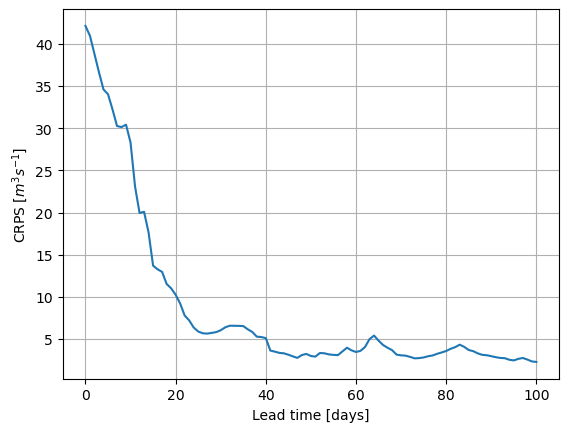

In [9]:
# We can explore and plot the CRPS as a function of lead-time, for example. Results are stored as a dataset and
# can thus be integrated into any simulation or processes.
plt.plot(crps_verif.q_sim)
plt.xlabel("Lead time [days]")
plt.ylabel("CRPS $[m^3s^{-1}]$")
plt.grid("on")
plt.show()